*Требования*:
*   оберните весь конвейер преобразований в Pipeline
*   подберите оптимальный вариант прогнозной модели с помощью GridSearchCV
*   примените обученный на тренировочных данных конвейер к тестовым данным, никак не предобрабатывая их, а лишь загрузив из файла и отделив целевой признак от остальных
*   получите на тестовой части качество не ниже 0.87 по метрике ROCAUC
Пояснение: если пропуски в новых данных и будут, то только в тех колонках, где они есть в тренировочной части.

# 1. Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

# 2. Подгрузим данные. Проанализируем данные.

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/W1llAnn/1tdata-homework/main/2.8heart_adapt_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/W1llAnn/1tdata-homework/main/2.8heart_adapt_test.csv')

*Посмотрим, что за данные у нас есть:*

In [3]:
train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,74.0,M,NAP,138.0,NaN,0,Normal,116,N,0.2,Up,0
1,58.0,M,NAP,132.0,224.0,0,LVH,173,N,3.2,Up,1
2,44.0,M,ATA,150.0,288.0,0,Normal,150,Y,3.0,Flat,1
3,50.0,M,ASY,144.0,349.0,0,LVH,120,Y,1.0,Up,1
4,NaN,M,ASY,145.0,248.0,0,Normal,96,Y,2.0,Flat,1


In [4]:
test.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,44.0,M,NAP,130.0,233.0,0,Normal,179,Y,0.4,Up,0
1,63.0,M,ASY,130.0,308.0,0,Normal,138,Y,2.0,Flat,1
2,35.0,F,TA,120.0,160.0,0,ST,185,N,0.0,Up,0
3,69.0,M,NAP,140.0,NaN,1,ST,118,N,2.5,Down,1
4,NaN,M,TA,142.0,200.0,1,ST,100,N,1.5,Down,1


**Одинаковое количество колонок, данные уже поделены на обучающую и тестовую выборку. Наша целевая переменная - HeartDisease.**

*Теперь посмотрим "поближе", проверим пропуски и дубликаты.*

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             533 non-null    float64
 1   Sex             589 non-null    object 
 2   ChestPainType   589 non-null    object 
 3   RestingBP       588 non-null    float64
 4   Cholesterol     462 non-null    float64
 5   FastingBS       589 non-null    int64  
 6   RestingECG      589 non-null    object 
 7   MaxHR           589 non-null    int64  
 8   ExerciseAngina  589 non-null    object 
 9   Oldpeak         589 non-null    float64
 10  ST_Slope        589 non-null    object 
 11  HeartDisease    589 non-null    int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 55.3+ KB


In [6]:
train.isnull().sum()

Age                56
Sex                 0
ChestPainType       0
RestingBP           1
Cholesterol       127
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

**В train есть пропуски в колонках Age, RestingBP, Cholesterol**

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             177 non-null    float64
 1   Sex             197 non-null    object 
 2   ChestPainType   197 non-null    object 
 3   RestingBP       197 non-null    float64
 4   Cholesterol     160 non-null    float64
 5   FastingBS       197 non-null    int64  
 6   RestingECG      197 non-null    object 
 7   MaxHR           197 non-null    int64  
 8   ExerciseAngina  197 non-null    object 
 9   Oldpeak         197 non-null    float64
 10  ST_Slope        197 non-null    object 
 11  HeartDisease    197 non-null    int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 18.6+ KB


In [8]:
test.isnull().sum()

Age               20
Sex                0
ChestPainType      0
RestingBP          0
Cholesterol       37
FastingBS          0
RestingECG         0
MaxHR              0
ExerciseAngina     0
Oldpeak            0
ST_Slope           0
HeartDisease       0
dtype: int64

**В test есть пропуски Age, Cholesterol**

**В обоих DataFrame мы видим следующие типы: float64 - 4 столбца, int64 - 3 столбца, object - 5 столбцов. С float64 и int64 можно работать, а вот object нужно будет преобразовывать.**

*Сбалансированность классов:*

In [9]:
train['HeartDisease'].value_counts()

HeartDisease
1    381
0    208
Name: count, dtype: int64

In [10]:
test['HeartDisease'].value_counts()

HeartDisease
1    127
0     70
Name: count, dtype: int64

**Классы не сбалансированы, это мы будем учитывать в самой модели**

*Визуализируем данные:*

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RestingBP'}>,
        <Axes: title={'center': 'Cholesterol'}>],
       [<Axes: title={'center': 'FastingBS'}>,
        <Axes: title={'center': 'MaxHR'}>,
        <Axes: title={'center': 'Oldpeak'}>],
       [<Axes: title={'center': 'HeartDisease'}>, <Axes: >, <Axes: >]],
      dtype=object)

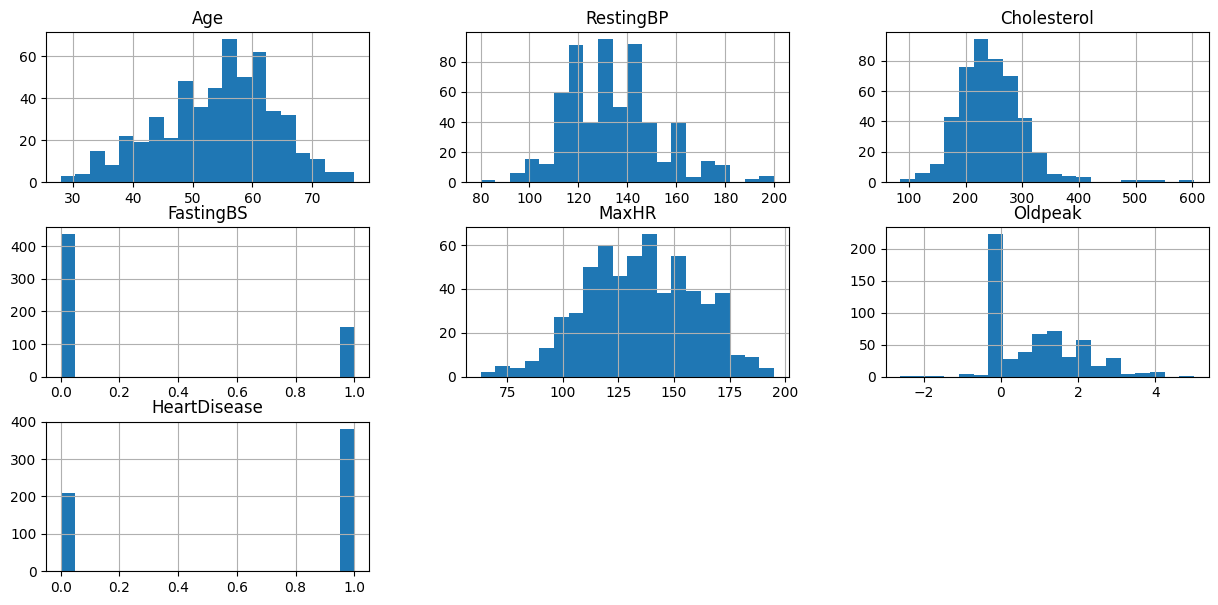

In [11]:
train.hist(bins=20, figsize=(15,7))

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RestingBP'}>,
        <Axes: title={'center': 'Cholesterol'}>],
       [<Axes: title={'center': 'FastingBS'}>,
        <Axes: title={'center': 'MaxHR'}>,
        <Axes: title={'center': 'Oldpeak'}>],
       [<Axes: title={'center': 'HeartDisease'}>, <Axes: >, <Axes: >]],
      dtype=object)

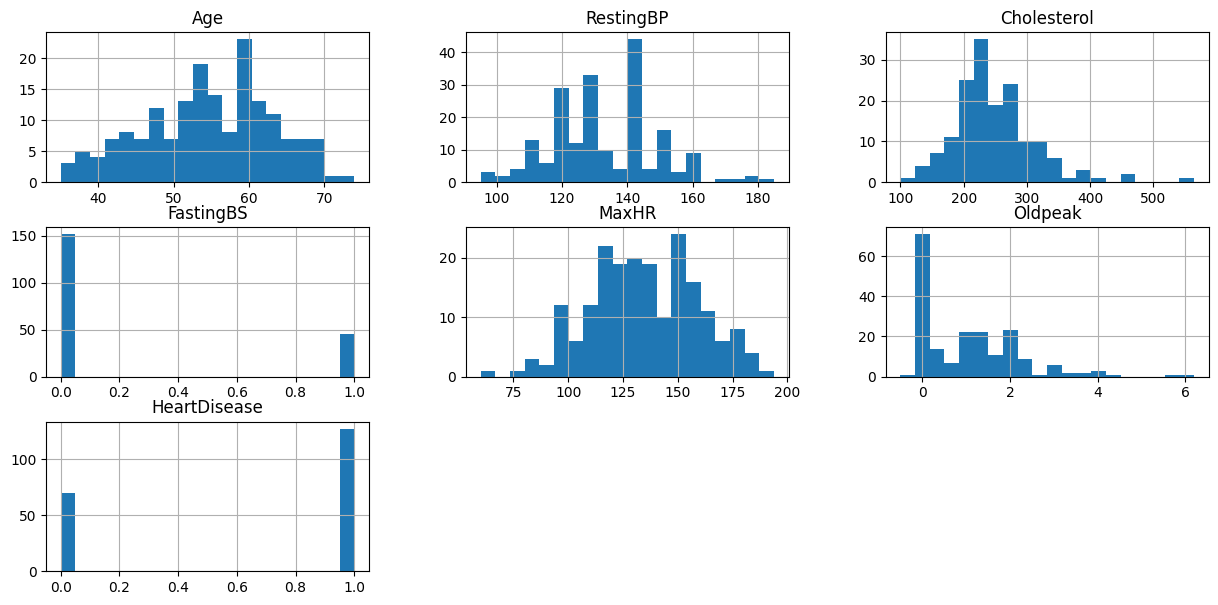

In [12]:
test.hist(bins=20, figsize=(15,7))

**Что мы можем сказать о наших данных, смотря на обе выборки:**
*   большая часть строк имеют показатель Age от 40 до 65 (примерно)
*   кровяное давление RestingBP у большинства находится от 100 до 150
*   Cholesterol возможно есть неверные данные, так как 0 холестирина в крови есть в некоторых строках
*   Уровень сахара в крови FastingBS у большинства в норме (0)
*   Максимальная частота сердечных сокращений MaxHR у большинства по выборке в диапазоне 100-175
*   Самый часто встречающийся показатель Oldpeak от -0,3 до 1
*   HeartDisease больше половины выборки имеют болезни сердца

*Теперь дубликаты:*

In [13]:
print(f'Дубликаты в train {len(train)- len(train.drop_duplicates ())}')
print(f'Дубликаты в test {len(test)- len(test.drop_duplicates ())}')

Дубликаты в train 0
Дубликаты в test 0


**Дубликаты отсутствуют**

<Axes: title={'center': 'Выбросы train'}>

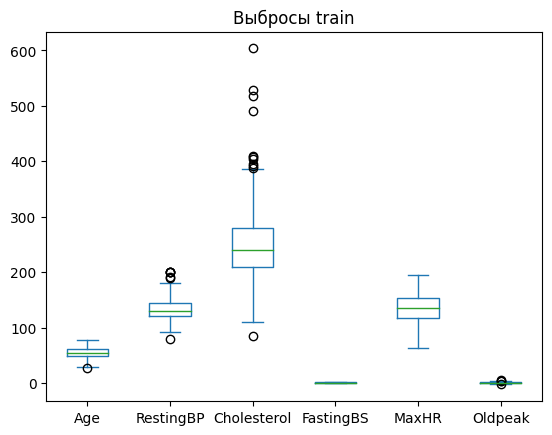

In [14]:
train[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']].plot.box(title='Выбросы train')

<Axes: title={'center': 'Выбросы test'}>

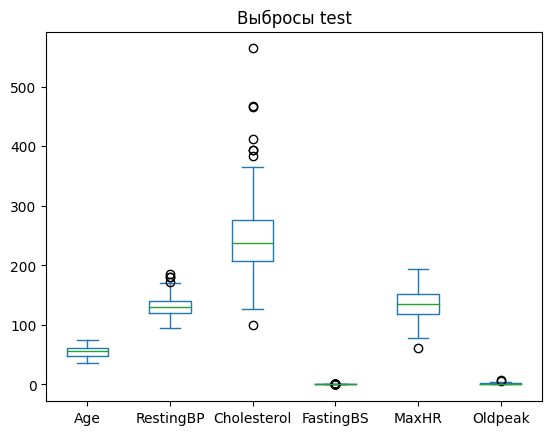

In [15]:
test[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']].plot.box(title='Выбросы test')

**В целом, мы определяем некоторые наблюдения как выбросы, но на рекуций момент, не будем их убирать, так как они могут быть "ложными", однако, будем держать это в уме.**

**Вывод по 2 пункту:**

1. Целевая переменная - HeartDisease.
2. Классы не сбалансированы, это мы будем учитывать в самой модели
3. Заполним пропуски:
*   Age - Средним значением по выборке
*   RestingBP - Средним значением по выборке
*   Cholesterol - Средним значением по выборке
4. Преобразуем object:
*   Sex (пол) - get_dummies
*   ChestPainType (тип боли в груди) - get_dummies
*   RestingECG (кровяное давление) - get_dummies
*   ExerciseAngina (стенакордия) - get_dummies
*   ST_Slope - get_dummies

# 3. Предобработка train выборки
# 4. Pipeline и GridSearchCV. Переберем несколько вариантов, с помощью кросс-валидации
# 5. Применим обученный на тренировочных данных конвейер к тестовым данным, никак не предобрабатывая их, а лишь загрузив из файла и отделив целевой признак от остальных

*Сначала отделим целевую переменную*

In [16]:
X_train = train.drop(['HeartDisease'], axis=1)
y_train = train['HeartDisease']

*Обучим модель и посмотрим на качество:*

In [34]:
categorical_train = list(X_train.select_dtypes('object').columns)
numerical_train = list(X_train.select_dtypes('number').columns)

cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary'))
])
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical_train),
    ('num', num_pipe, numerical_train)
])


pipe = Pipeline([  
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('classify', RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators = 100, random_state=0))
])


pipe.fit(X=X_train, y=y_train)
print('Качество модели на обучающей выборке:', {roc_auc_score(y_train, pipe.predict_proba(X_train)[:, 1])})

Качество модели на обучающей выборке: {0.9754694124772866}


**Качество модели на обучающей выборке 1.0, скорее всего модель переобучена**

*Теперь к тестовой*

In [35]:
X_test = test.drop(['HeartDisease'], axis=1)
y_test = test['HeartDisease']

In [38]:
params = [
    {'classify': [LogisticRegression(class_weight='balanced', random_state=0)]}, 

    {'classify': [DecisionTreeClassifier(class_weight='balanced', random_state=0)], 'classify__max_depth': [1, 2, 5, 10, 20, 30]},
    {'classify': [DecisionTreeClassifier(class_weight='balanced', random_state=0)], 'classify__min_samples_split': [2, 3, 4, 5, 10]},
    {'classify': [DecisionTreeClassifier(class_weight='balanced', random_state=0)], 'classify__min_samples_leaf': [1, 2, 3, 4, 5]},

    {'classify': [RandomForestClassifier(class_weight='balanced', random_state=0)], 'classify__max_depth': [1, 2, 3, 4, 5, 8, 10]},
    {'classify': [RandomForestClassifier(class_weight='balanced', random_state=0)], 'classify__n_estimators': [10, 20, 40, 60, 80, 100, 120, 140, 160]},
    {'classify': [RandomForestClassifier(class_weight='balanced', random_state=0)], 'classify__min_samples_split': [2, 3, 4, 5, 10]},
    {'classify': [RandomForestClassifier(class_weight='balanced', random_state=0)], 'classify__min_samples_leaf': [2, 3, 4, 5, 10]},

    {'classify': [GradientBoostingClassifier(random_state=0, learning_rate=1.0)], 'classify__n_estimators': [10, 20, 40, 60, 80, 100, 120]},
    {'classify': [GradientBoostingClassifier(random_state=0, learning_rate=1.0)], 'classify__max_depth': [1, 2, 3, 4, 5]},

    {'classify': [linear_model.LinearRegression()]},
    
    {'classify': [GaussianNB()]},

    {'classify': [BaggingClassifier(DecisionTreeClassifier(class_weight='balanced', random_state=0, max_depth=2))], 'classify__n_estimators': [10, 20, 30, 40, 50, 100]},

]

grid_search = GridSearchCV(pipe, param_grid=params, cv=5, scoring='roc_auc')
grid_search.fit(X=X_train, y=y_train)
print(
    'Качество модели на тестовой выборке c лучшей моделью:', 
    {roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1])}
)

Качество модели на тестовой выборке c лучшей моделью: {0.9069178852643419}


In [39]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak'])])),
                ('scaler', StandardScaler()),
                ('classify',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=120, random_state=0))])

In [40]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [41]:
df_model = pd.DataFrame.from_dict(grid_search.cv_results_).transpose()
df_2 = df_model.iloc [[9, 15, -1]].T
df_2 = df_2.sort_values(by=['rank_test_score'])
df_2.head(10)

,params,mean_test_score,rank_test_score
30,"{'classify': RandomForestClassifier(class_weight='balanced', n_estimators=120, random_state=0), 'classify__n_estimators': 120}",0.937501,1
32,"{'classify': RandomForestClassifier(class_weight='balanced', n_estimators=120, random_state=0), 'classify__n_estimators': 160}",0.937353,2
23,"{'classify': RandomForestClassifier(class_weight='balanced', random_state=0), 'classify__max_depth': 10}",0.936687,3
36,"{'classify': RandomForestClassifier(class_weight='balanced', random_state=0), 'classify__min_samples_split': 5}",0.936536,4
31,"{'classify': RandomForestClassifier(class_weight='balanced', n_estimators=120, random_state=0), 'classify__n_estimators': 140}",0.936355,5
28,"{'classify': RandomForestClassifier(class_weight='balanced', n_estimators=120, random_state=0), 'classify__n_estimators': 80}",0.936007,6
29,"{'classify': RandomForestClassifier(class_weight='balanced', n_estimators=120, random_state=0), 'classify__n_estimators': 100}",0.935947,7
33,"{'classify': RandomForestClassifier(class_weight='balanced', random_state=0), 'classify__min_samples_split': 2}",0.935947,7
21,"{'classify': RandomForestClassifier(class_weight='balanced', random_state=0), 'classify__max_depth': 5}",0.935755,9
41,"{'classify': RandomForestClassifier(class_weight='balanced', random_state=0), 'classify__min_samples_leaf': 5}",0.935482,10


**Теперь мы можем посмотреть первые 10 моделей, это RandomForestClassifier с разными параметрами.**

# Выводы

Какую работу мы провели:
*   Проанализировали датасет, нашли пропуски в данных
*   Создали Pipeline, который сначала обрабатывает пропуски и преобразовывает данные, затем производит маштабирование StandardScaler и переходит к модели
*   Через GridSearchCV посчитали roc_auc для следующих моделей: LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier, LinearRegression, GaussianNB и попробовали BaggingClassifier асамблировать DecisionTreeClassifier

По результатам моделей:
* Лучшей моделью из всего списка стала RandomForestClassifier(class_weight='balanced', min_samples_leaf=10, random_state=0), и первые 10 "мест" занимают RandomForestClassifier с разными параметрами

Да и в целом, они не критично друг от друга отличаются.

**Итог.** Мы смогли получить на тестовой части качество 0.907 по метрике ROCAUC, это получилось сделать модели RandomForestClassifier с параметрами class_weight='balanced', n_estimators=120, random_state=0